# Road Follower - Train Model

In this notebook we will train a neural network to take an input image, and output a set of x, y values corresponding to a target.

We will be using PyTorch deep learning framework to train ResNet18 neural network architecture model for road follower application.

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
from ignite.handlers import ModelCheckpoint
import time

### Download and extract data

Before you start, you should upload the ``road_following_<Date&Time>.zip`` file that you created in the ``data_collection.ipynb`` notebook on the robot. 

> If you're training on the JetBot you collected data on, you can skip this!

You should then extract this dataset by calling the command below:

In [1]:
def preprocess_image(image_path, image):
    x = float(get_x(os.path.basename(image_path)))
    y = float(get_y(os.path.basename(image_path)))

    color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    image = color_jitter(image)
    image = transforms.functional.resize(image, (224, 224))
    image = transforms.functional.to_tensor(image)
    image = image.numpy()[::-1].copy()
    image = torch.from_numpy(image)
    image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    return image, torch.tensor([x, y]).float()

### Create Dataset Instance

Here we create a custom ``torch.utils.data.Dataset`` implementation, which implements the ``__len__`` and ``__getitem__`` functions.  This class
is responsible for loading images and parsing the x, y values from the image filenames.  Because we implement the ``torch.utils.data.Dataset`` class,
we can use all of the torch data utilities :)

We hard coded some transformations (like color jitter) into our dataset.  We made random horizontal flips optional (in case you want to follow a non-symmetric path, like a road
where we need to 'stay right').  If it doesn't matter whether your robot follows some convention, you could enable flips to augment the dataset.

In [3]:
def get_x(path):
    """Gets the x value from the image filename"""
    return (float(int(path[3:6])) - 50.0) / 50.0

def get_y(path):
    """Gets the y value from the image filename"""
    return (float(int(path[7:10])) - 50.0) / 50.0

image_paths = glob.glob(os.path.join('dataset_xy', '*.jpg'))

import matplotlib.pyplot as plt
from PIL import Image


augmented_dataset = []
for image_path in image_paths:
    original_image = PIL.Image.open(image_path)
    brightness_enhancer = PIL.ImageEnhance.Brightness(original_image)
#     mode_image = original_image.filter(PIL.ImageFilter.ModeFilter(5))        
#     blurred_image = original_image.filter(PIL.ImageFilter.GaussianBlur(5))   
#     sharp_image = original_image.filter(PIL.ImageFilter.UnsharpMask(7))   
#     enhanced_image = original_image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE())
    dark_image = brightness_enhancer.enhance(0.4)
#     bright_image = brightness_enhancer.enhance(3)

    augmented_dataset.append(preprocess_image(image_path, original_image))            
#     augmented_dataset.append(pre_process_pil_image(image_path, mode_image))
    augmented_dataset.append(preprocess_image(image_path, dark_image))
#     augmented_dataset.append(pre_process_pil_image(image_path, bright_image))


In [4]:
len(augmented_dataset)

1124

In [5]:
len(image_paths)

562

### Split dataset into train and test sets
Once we read dataset, we will split data set in train and test sets. In this example we split train and test a 90%-10%. The test set will be used to verify the accuracy of the model we train.

In [6]:
test_percent = 0.4
num_test = int(test_percent * len(augmented_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [len(augmented_dataset) - num_test, num_test])

### Create data loaders to load data in batches

We use ``DataLoader`` class to load data in batches, shuffle data and allow using multi-subprocesses. In this example we use batch size of 64. Batch size will be based on memory available with your GPU and it can impact accuracy of the model.

### Define Neural Network Model 

We use ResNet-18 model available on PyTorch TorchVision. 

In a process called transfer learning, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.


More details on ResNet-18 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

More Details on Transfer Learning: https://www.youtube.com/watch?v=yofjFQddwHE 

ResNet model has fully connect (fc) final layer with 512 as ``in_features`` and we will be training for regression thus ``out_features`` as 1

Finally, we transfer our model for execution on the GPU

<span style="font-family: Arial; font-size:1.4em;color:blue;">The restnet model layers</span>

### Train Regression:

We train for 50 epochs and save best model if the loss is reduced. 

Once the model is trained, it will generate ``best_steering_model_xy.pth`` file which you can use for inferencing in the live demo notebook.

If you trained on a different machine other than JetBot, you'll need to upload this to the JetBot to the ``road_following`` example folder.

In [11]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, MeanSquaredError, RunningAverage, ConfusionMatrix
from ignite.contrib.handlers import ProgressBar

log_interval = 50
NUM_EPOCHS= 50


model = models.resnet18(pretrained=True, progress=True)


def freeze_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_parameters(model)


model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)



def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y =batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_function(engine, batch):
    model.eval()
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    return y_pred, y


def thresholded_output_transform(output):
    y_pred, y = output
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred = torch.round(y_pred)
    y_tag = torch.round(torch.sigmoid(y))
    y = torch.round(y_pred)
    return  y_pred_tag, y_tag


trainer = Engine(process_function)
train_evaluator = Engine(eval_function)
validation_evaluator = Engine(eval_function)


RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')


Accuracy(output_transform=thresholded_output_transform).attach(train_evaluator, 'accuracy')
Loss(criterion).attach(train_evaluator, 'ce')


Accuracy(output_transform=thresholded_output_transform).attach(validation_evaluator, 'accuracy')
Loss(criterion).attach(validation_evaluator, 'ce')


pbar = ProgressBar(persist=True, bar_format="")
pbar.attach(trainer, ['loss'])

training_history_acc = []
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(trainer):
    print("Epoch[{}] Loss: {:.4f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics["accuracy"])
    training_history['loss'].append(metrics["ce"])
    print("Training Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["ce"]))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    
    validation_history['accuracy'].append(metrics["accuracy"])
    validation_history['loss'].append(metrics["ce"])
    print("Validation Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["ce"]))


def score_function(engine):
    val_loss = engine.state.metrics['ce']
    return val_loss

checkpointer = ModelCheckpoint('checkpoint', 
                               'best_model_18_feature',
                               save_interval=1,
                               n_saved=2,
                               create_dir=True,
                               require_empty=False,
                               save_as_state_dict=True)

best_model_save = ModelCheckpoint('best_model_18_feature',
                                  'best_model_18_feature',
                                  n_saved=1,create_dir=True,
                                  save_as_state_dict=True,
                                  require_empty=True,
                                  score_function=score_function)


trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'steering': model})
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, best_model_save, {'steering': model})

since = time.time()

trainer.run(train_loader, max_epochs=NUM_EPOCHS)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch[1] Loss: 0.1297

Training Results - Epoch: 1  Avg accuracy: 0.635 Avg loss: 0.1231
Validation Results - Epoch: 1  Avg accuracy: 0.626 Avg loss: 0.1105


Epoch[2] Loss: 0.1017
Epoch[2] Loss: 0.0831

Training Results - Epoch: 2  Avg accuracy: 0.681 Avg loss: 0.0962
Validation Results - Epoch: 2  Avg accuracy: 0.677 Avg loss: 0.0852


Epoch[3] Loss: 0.1083
Epoch[3] Loss: 0.0381

Training Results - Epoch: 3  Avg accuracy: 0.709 Avg loss: 0.0863
Validation Results - Epoch: 3  Avg accuracy: 0.685 Avg loss: 0.0776


Epoch[4] Loss: 0.0678

Training Results - Epoch: 4  Avg accuracy: 0.727 Avg loss: 0.0744
Validation Results - Epoch: 4  Avg accuracy: 0.717 Avg loss: 0.0682


Epoch[5] Loss: 0.0333
Epoch[5] Loss: 0.0186

Training Results - Epoch: 5  Avg accuracy: 0.733 Avg loss: 0.0661
Validation Results - Epoch: 5  Avg accuracy: 0.717 Avg loss: 0.0643


Epoch[6] Loss: 0.0530
Epoch[6] Loss: 0.0157

Training Results - Epoch: 6  Avg accuracy: 0.767 Avg loss: 0.0591
Validation Results - Epoch: 6  Avg accuracy: 0.758 Avg loss: 0.0590


Epoch[7] Loss: 0.0192

Training Results - Epoch: 7  Avg accuracy: 0.779 Avg loss: 0.0553
Validation Results - Epoch: 7  Avg accuracy: 0.754 Avg loss: 0.0561


Epoch[8] Loss: 0.0300
Epoch[8] Loss: 0.0825

Training Results - Epoch: 8  Avg accuracy: 0.791 Avg loss: 0.0535
Validation Results - Epoch: 8  Avg accuracy: 0.782 Avg loss: 0.0533


Epoch[9] Loss: 0.0361
Epoch[9] Loss: 0.0396

Training Results - Epoch: 9  Avg accuracy: 0.797 Avg loss: 0.0471
Validation Results - Epoch: 9  Avg accuracy: 0.772 Avg loss: 0.0485


Epoch[10] Loss: 0.0449
Epoch[10] Loss: 0.0543

Training Results - Epoch: 10  Avg accuracy: 0.780 Avg loss: 0.0430
Validation Results - Epoch: 10  Avg accuracy: 0.763 Avg loss: 0.0462


Epoch[11] Loss: 0.0498

Training Results - Epoch: 11  Avg accuracy: 0.771 Avg loss: 0.0413
Validation Results - Epoch: 11  Avg accuracy: 0.761 Avg loss: 0.0452


Epoch[12] Loss: 0.0693
Epoch[12] Loss: 0.0446

Training Results - Epoch: 12  Avg accuracy: 0.817 Avg loss: 0.0374
Validation Results - Epoch: 12  Avg accuracy: 0.786 Avg loss: 0.0437


Epoch[13] Loss: 0.0254
Epoch[13] Loss: 0.0244

Training Results - Epoch: 13  Avg accuracy: 0.782 Avg loss: 0.0355
Validation Results - Epoch: 13  Avg accuracy: 0.761 Avg loss: 0.0392


Epoch[14] Loss: 0.0426

Training Results - Epoch: 14  Avg accuracy: 0.812 Avg loss: 0.0351
Validation Results - Epoch: 14  Avg accuracy: 0.780 Avg loss: 0.0400


Epoch[15] Loss: 0.0398
Epoch[15] Loss: 0.0310

Training Results - Epoch: 15  Avg accuracy: 0.833 Avg loss: 0.0347
Validation Results - Epoch: 15  Avg accuracy: 0.808 Avg loss: 0.0389


Epoch[16] Loss: 0.0379
Epoch[16] Loss: 0.0271

Training Results - Epoch: 16  Avg accuracy: 0.827 Avg loss: 0.0301
Validation Results - Epoch: 16  Avg accuracy: 0.797 Avg loss: 0.0356


Epoch[17] Loss: 0.0092

Training Results - Epoch: 17  Avg accuracy: 0.810 Avg loss: 0.0304
Validation Results - Epoch: 17  Avg accuracy: 0.802 Avg loss: 0.0351


Epoch[18] Loss: 0.0382
Epoch[18] Loss: 0.0301

Training Results - Epoch: 18  Avg accuracy: 0.843 Avg loss: 0.0275
Validation Results - Epoch: 18  Avg accuracy: 0.817 Avg loss: 0.0340


Epoch[19] Loss: 0.0315
Epoch[19] Loss: 0.0172

Training Results - Epoch: 19  Avg accuracy: 0.813 Avg loss: 0.0286
Validation Results - Epoch: 19  Avg accuracy: 0.795 Avg loss: 0.0330


Epoch[20] Loss: 0.0241
Epoch[20] Loss: 0.0432

Training Results - Epoch: 20  Avg accuracy: 0.799 Avg loss: 0.0276
Validation Results - Epoch: 20  Avg accuracy: 0.771 Avg loss: 0.0331


Epoch[21] Loss: 0.0090

Training Results - Epoch: 21  Avg accuracy: 0.838 Avg loss: 0.0254
Validation Results - Epoch: 21  Avg accuracy: 0.811 Avg loss: 0.0311


Epoch[22] Loss: 0.0285
Epoch[22] Loss: 0.0152

Training Results - Epoch: 22  Avg accuracy: 0.833 Avg loss: 0.0246
Validation Results - Epoch: 22  Avg accuracy: 0.821 Avg loss: 0.0303


Epoch[23] Loss: 0.0279
Epoch[23] Loss: 0.0141

Training Results - Epoch: 23  Avg accuracy: 0.825 Avg loss: 0.0240
Validation Results - Epoch: 23  Avg accuracy: 0.803 Avg loss: 0.0302


Epoch[24] Loss: 0.0153

Training Results - Epoch: 24  Avg accuracy: 0.812 Avg loss: 0.0231
Validation Results - Epoch: 24  Avg accuracy: 0.801 Avg loss: 0.0283


Epoch[25] Loss: 0.0260
Epoch[25] Loss: 0.0108

Training Results - Epoch: 25  Avg accuracy: 0.847 Avg loss: 0.0231
Validation Results - Epoch: 25  Avg accuracy: 0.833 Avg loss: 0.0292


Epoch[26] Loss: 0.0680
Epoch[26] Loss: 0.0327

Training Results - Epoch: 26  Avg accuracy: 0.834 Avg loss: 0.0226
Validation Results - Epoch: 26  Avg accuracy: 0.820 Avg loss: 0.0280


Epoch[27] Loss: 0.0297

Training Results - Epoch: 27  Avg accuracy: 0.847 Avg loss: 0.0217
Validation Results - Epoch: 27  Avg accuracy: 0.817 Avg loss: 0.0281


Epoch[28] Loss: 0.0296
Epoch[28] Loss: 0.0135

Training Results - Epoch: 28  Avg accuracy: 0.844 Avg loss: 0.0203
Validation Results - Epoch: 28  Avg accuracy: 0.833 Avg loss: 0.0260


Epoch[29] Loss: 0.0190
Epoch[29] Loss: 0.0141

Training Results - Epoch: 29  Avg accuracy: 0.844 Avg loss: 0.0197
Validation Results - Epoch: 29  Avg accuracy: 0.830 Avg loss: 0.0260


Epoch[30] Loss: 0.0305
Epoch[30] Loss: 0.0090

Training Results - Epoch: 30  Avg accuracy: 0.843 Avg loss: 0.0193
Validation Results - Epoch: 30  Avg accuracy: 0.818 Avg loss: 0.0256


Epoch[31] Loss: 0.0251

Training Results - Epoch: 31  Avg accuracy: 0.860 Avg loss: 0.0199
Validation Results - Epoch: 31  Avg accuracy: 0.846 Avg loss: 0.0257


Epoch[32] Loss: 0.0382
Epoch[32] Loss: 0.0306

Training Results - Epoch: 32  Avg accuracy: 0.859 Avg loss: 0.0189
Validation Results - Epoch: 32  Avg accuracy: 0.842 Avg loss: 0.0243


Epoch[33] Loss: 0.0164
Epoch[33] Loss: 0.0183

Training Results - Epoch: 33  Avg accuracy: 0.837 Avg loss: 0.0181
Validation Results - Epoch: 33  Avg accuracy: 0.824 Avg loss: 0.0245


Epoch[34] Loss: 0.0191

Training Results - Epoch: 34  Avg accuracy: 0.875 Avg loss: 0.0220
Validation Results - Epoch: 34  Avg accuracy: 0.843 Avg loss: 0.0286


Epoch[35] Loss: 0.0210
Epoch[35] Loss: 0.0245

Training Results - Epoch: 35  Avg accuracy: 0.845 Avg loss: 0.0178
Validation Results - Epoch: 35  Avg accuracy: 0.839 Avg loss: 0.0235


Epoch[36] Loss: 0.0067
Epoch[36] Loss: 0.0296

Training Results - Epoch: 36  Avg accuracy: 0.837 Avg loss: 0.0173
Validation Results - Epoch: 36  Avg accuracy: 0.833 Avg loss: 0.0230


Epoch[37] Loss: 0.0123

Training Results - Epoch: 37  Avg accuracy: 0.858 Avg loss: 0.0167
Validation Results - Epoch: 37  Avg accuracy: 0.835 Avg loss: 0.0236


Epoch[38] Loss: 0.0174
Epoch[38] Loss: 0.0048

Training Results - Epoch: 38  Avg accuracy: 0.842 Avg loss: 0.0177
Validation Results - Epoch: 38  Avg accuracy: 0.832 Avg loss: 0.0233


Epoch[39] Loss: 0.0217
Epoch[39] Loss: 0.0164

Training Results - Epoch: 39  Avg accuracy: 0.858 Avg loss: 0.0161
Validation Results - Epoch: 39  Avg accuracy: 0.841 Avg loss: 0.0226


Epoch[40] Loss: 0.0092
Epoch[40] Loss: 0.0369

Training Results - Epoch: 40  Avg accuracy: 0.842 Avg loss: 0.0157
Validation Results - Epoch: 40  Avg accuracy: 0.836 Avg loss: 0.0218


Epoch[41] Loss: 0.0282

Training Results - Epoch: 41  Avg accuracy: 0.866 Avg loss: 0.0172
Validation Results - Epoch: 41  Avg accuracy: 0.851 Avg loss: 0.0236


Epoch[42] Loss: 0.0164
Epoch[42] Loss: 0.0114

Training Results - Epoch: 42  Avg accuracy: 0.836 Avg loss: 0.0151
Validation Results - Epoch: 42  Avg accuracy: 0.829 Avg loss: 0.0209


Epoch[43] Loss: 0.0062
Epoch[43] Loss: 0.0240

Training Results - Epoch: 43  Avg accuracy: 0.879 Avg loss: 0.0161
Validation Results - Epoch: 43  Avg accuracy: 0.864 Avg loss: 0.0227


Epoch[44] Loss: 0.0211

Training Results - Epoch: 44  Avg accuracy: 0.861 Avg loss: 0.0148
Validation Results - Epoch: 44  Avg accuracy: 0.844 Avg loss: 0.0215


Epoch[45] Loss: 0.0085
Epoch[45] Loss: 0.0056

Training Results - Epoch: 45  Avg accuracy: 0.861 Avg loss: 0.0144
Validation Results - Epoch: 45  Avg accuracy: 0.847 Avg loss: 0.0204


Epoch[46] Loss: 0.0273
Epoch[46] Loss: 0.0158

Training Results - Epoch: 46  Avg accuracy: 0.869 Avg loss: 0.0145
Validation Results - Epoch: 46  Avg accuracy: 0.847 Avg loss: 0.0208


Epoch[47] Loss: 0.0108

Training Results - Epoch: 47  Avg accuracy: 0.866 Avg loss: 0.0147
Validation Results - Epoch: 47  Avg accuracy: 0.855 Avg loss: 0.0211


Epoch[48] Loss: 0.0246
Epoch[48] Loss: 0.0080

Training Results - Epoch: 48  Avg accuracy: 0.876 Avg loss: 0.0151
Validation Results - Epoch: 48  Avg accuracy: 0.856 Avg loss: 0.0209


Epoch[49] Loss: 0.0199
Epoch[49] Loss: 0.0099

Training Results - Epoch: 49  Avg accuracy: 0.818 Avg loss: 0.0150
Validation Results - Epoch: 49  Avg accuracy: 0.816 Avg loss: 0.0195


Epoch[50] Loss: 0.0169
Epoch[50] Loss: 0.0136

Training Results - Epoch: 50  Avg accuracy: 0.836 Avg loss: 0.0139
Validation Results - Epoch: 50  Avg accuracy: 0.822 Avg loss: 0.0191
Training complete in 17m 46s


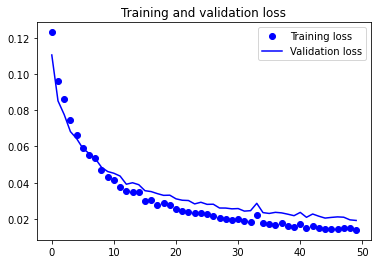

In [12]:
epochs = range(NUM_EPOCHS)
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, training_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, validation_history['loss'], 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

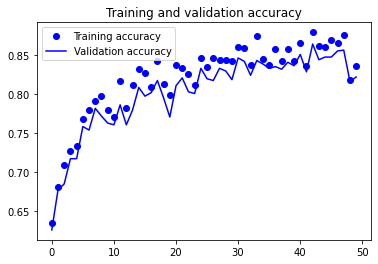

In [14]:
plt.figure()


plt.plot(epochs, training_history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, validation_history['accuracy'], 'b', label='Validation accuracy')
# plt.plot(epochs, state.metrics['loss'], 'r', label='loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()